# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

## Read in the datafile with Pandas and do some exploration of the data

In [2]:
import numpy as np
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [3]:
# check the data types
df.dtypes

ID            object
Date          object
Element       object
Data_Value     int64
dtype: object

In [4]:
print('There are {} observations in the dataset with {} features.'.format(len(df), len(df.columns)))

There are 165085 observations in the dataset with 4 features.


In [5]:
# we can see from the query below some stations only have one reading on given days, 
# but most have at most 2 readings on a given day
# df.groupby(['ID','Date']).size().sort_values().head()

### Create extra date fields on the dataframe that we'll need & Sort by Datetime

In [6]:
#create a year & month field so we can group on that later
df['DayofYear'] = df['Date'].apply(lambda x: x[5:])
df['Year'] = df['Date'].apply(lambda x: x[:4])

# now convert the Date field to a datetime field
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace = True)
df['Year'] = pd.to_numeric(df['Year'])
df.head()

,ID,Date,Element,Data_Value,DayofYear,Year
60995,USW00004848,2005-01-01,TMIN,0,01-01,2005
17153,USC00207320,2005-01-01,TMAX,150,01-01,2005
17155,USC00207320,2005-01-01,TMIN,-11,01-01,2005
10079,USW00014833,2005-01-01,TMIN,-44,01-01,2005
10073,USW00014833,2005-01-01,TMAX,33,01-01,2005


In [7]:
# check that our data conversion to date went through and our new data types
df.dtypes

ID                    object
Date          datetime64[ns]
Element               object
Data_Value             int64
DayofYear             object
Year                   int64
dtype: object

### Create the data to be plot between 2005 and 2014 

In [8]:
def get_lows_and_highs(yearstart, yearend,temp=None):
    """function for returning either record highs or record low
    temp = TMAX/TMIN
    yearstart: enter a value that will be used as start year, greater than or equal to this value. 
    yearend: enter a value that is yearend + 1 for the function to select data not equal to this date.
    """
    
    #decide wether to use query for TMAX or TMIN values
    if temp =='TMAX':
        data = (
            df
            .loc[(df['Year']>=yearstart) & (df['Year']<yearend) & (df['Element']==temp) & (df['DayofYear']!='02-29') ,:]
            .groupby('DayofYear')
            .aggregate({'Data_Value':np.max})
            .rename(columns={'Data_Value':'RecordHigh'})
            .reset_index()
            )
    else: 
          data = (
            df
            .loc[(df['Year']>=yearstart) & (df['Year']<yearend) & (df['Element']==temp) & (df['DayofYear']!='02-29') ,:]
            .groupby('DayofYear')
            .aggregate({'Data_Value':np.min})
            .rename(columns={'Data_Value':'RecordLow'})
            .reset_index()
            )
    return data

### Create the plot to compare 2015 data points to determine broken records

In [9]:
max_2015 = get_lows_and_highs(2015,2016,'TMAX')
min_2015 = get_lows_and_highs(2015,2016,'TMIN')
max_2015_compare = pd.merge(get_lows_and_highs(2005,2015,'TMAX'), max_2015, on ='DayofYear', how ='left')
min_2015_compare = pd.merge(get_lows_and_highs(2005,2015,'TMIN'), min_2015, on ='DayofYear', how ='left')

max_2015_compare['Record 2015 High Point Broken'] = 1*(max_2015_compare['RecordHigh_y']>max_2015_compare['RecordHigh_x'])*max_2015_compare['RecordHigh_y']
min_2015_compare['Record 2015 Low Point Broken'] = 1*(min_2015_compare['RecordLow_y']<min_2015_compare['RecordLow_x'])*min_2015_compare['RecordLow_y']

### Creating the Line Plot

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


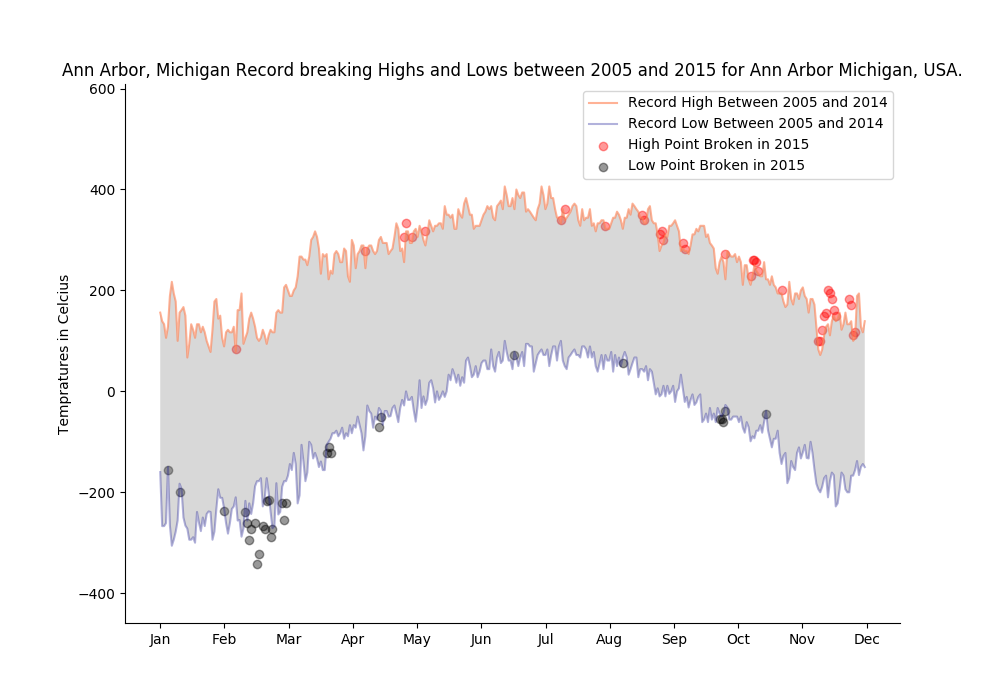

In [29]:
#define the figure and size properties for our main axes
plt.figure(figsize=(10,7))

#get unique dates here for use on x axis on line plot
uniquedates = pd.concat([get_lows_and_highs(2005, 2015,'TMAX'), get_lows_and_highs(2005, 2015,'TMIN')]).DayofYear.unique()

# setting up plot variables here 
x, highs = range(len(uniquedates)), get_lows_and_highs(2005, 2015,'TMAX')['RecordHigh']
lows = get_lows_and_highs(2005, 2015,'TMIN')['RecordLow']
high_broken = max_2015_compare.iloc[:,3].apply(lambda x:np.nan if x ==0 else x)
low_broken = min_2015_compare.iloc[:,3].apply(lambda x:np.nan if x ==0 else x)

# use these for labels
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# build the plot visualization now
plt.plot(x,highs, label = 'Record High Between 2005 and 2014', c='coral', alpha =0.6)
plt.plot(x,lows, label = 'Record Low Between 2005 and 2014', c='darkblue', alpha=0.3)
plt.scatter(x,high_broken, label = 'High Point Broken in 2015', c ='red', alpha=0.4)
plt.scatter(x,low_broken, label = 'Low Point Broken in 2015', c ='black', alpha=0.4)
plt.xticks(np.linspace(0,len(x),12),months)
plt.ylim(ymax=highs.max()*1.5, ymin=lows.min()*1.5)
plt.title('Ann Arbor, Michigan Record breaking Highs and Lows between {} and {} for Ann Arbor Michigan, USA.'.format(2005,2015))
plt.ylabel('Tempratures in Celcius')
plt.gca().fill_between(x,highs,lows,facecolor = 'gray',alpha = 0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc='best')

#finall show the plot in Jupyter notebook now
plt.show()